In [1]:
import os

base_dir = '/content/drive/MyDrive/Colab machine learning/Project Deployment/Animals 5'
list_animals = os.listdir(base_dir)
print(list_animals)

['butterfly', 'chicken', 'dog', 'horse', 'spider']


In [2]:
from PIL import Image

total_dataset = 0
for animals in list_animals:
  dir = os.path.join(base_dir, animals)
  total_img = len(os.listdir(dir))
  print(animals + ': ' + str(total_img))
  total_dataset = total_dataset + total_img

  img_name = os.listdir(dir)
  for i in range(4):
    img = Image.open(dir + '/' + img_name[i])
    print('-' + str(img.size))
  print('------------')

print('\nTotal Dataset : ', total_dataset)

butterfly: 2112
-(428, 640)
-(300, 225)
-(640, 428)
-(300, 201)
------------
chicken: 2500
-(220, 165)
-(300, 225)
-(300, 265)
-(300, 198)
------------
dog: 2500
-(225, 300)
-(300, 200)
-(300, 268)
-(300, 199)
------------
horse: 2500
-(225, 300)
-(300, 234)
-(300, 212)
-(300, 256)
------------
spider: 2500
-(640, 426)
-(300, 200)
-(640, 426)
-(300, 164)
------------

Total Dataset :  12112


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.2)
 
val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    fill_mode='nearest',
                    validation_split = 0.2)

In [4]:
my_batch_size = 32
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(200,200),
    batch_size=my_batch_size,
    shuffle=True,
    subset='training',
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=(200, 200),
    batch_size=my_batch_size,
    subset='validation',
    class_mode='categorical')

Found 9690 images belonging to 5 classes.
Found 2422 images belonging to 5 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2

model = tf.keras.models.Sequential([
    ResNet152V2(weights='imagenet', include_top=False, input_tensor=Input(shape=(200,200,3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')])
model.layers[0].trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=1.0000e-06),
              metrics=['accuracy'])

In [6]:
#membuat kelas callback untuk menghentikan training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>=0.95 and logs.get('val_accuracy')>=0.95:
      self.model.stop_training = True
      accuracy = float(logs.get('accuracy'))*100
      val_accuracy = float(logs.get('val_accuracy'))*100
      print("reached %.2f%% accuracy and %.2f%% val_accuracy" %(accuracy, val_accuracy))

callback = myCallback()

# from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [7]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    verbose=1,
    callbacks=[callback])

Epoch 1/30
303/303 [==============================] - 159s 490ms/step - loss: 4.1302 - accuracy: 0.3066 - val_loss: 2.1291 - val_accuracy: 0.4306
Epoch 2/30
303/303 [==============================] - 143s 472ms/step - loss: 1.3629 - accuracy: 0.5731 - val_loss: 0.8537 - val_accuracy: 0.7110
Epoch 3/30
303/303 [==============================] - 143s 472ms/step - loss: 0.7188 - accuracy: 0.7600 - val_loss: 0.5454 - val_accuracy: 0.8159
Epoch 4/30
303/303 [==============================] - 143s 472ms/step - loss: 0.5022 - accuracy: 0.8348 - val_loss: 0.4101 - val_accuracy: 0.8646
Epoch 5/30
303/303 [==============================] - 143s 472ms/step - loss: 0.4012 - accuracy: 0.8747 - val_loss: 0.3348 - val_accuracy: 0.8914
Epoch 6/30
303/303 [==============================] - 142s 467ms/step - loss: 0.3392 - accuracy: 0.8956 - val_loss: 0.2874 - val_accuracy: 0.9092
Epoch 7/30
303/303 [==============================] - 143s 473ms/step - loss: 0.2937 - accuracy: 0.9054 - val_loss: 0.2527 -

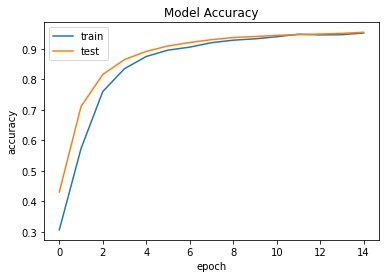

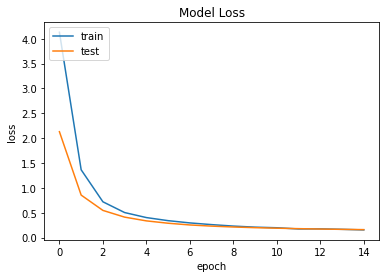

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

#plot accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# # Konversi model ke tflite
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# #menyimpan model
# with tf.io.gfile.GFile('model.tflite', 'wb') as f:
#   f.write(tflite_model)